In [2]:
!pip install opendatasets


In [1]:
!pip install jovian


In [2]:
# Imports
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import opendatasets as od
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import jovian
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
#Define the URL of the dataset
dataset_url = "https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?datasetId=8782&sortBy=voteCount"

# Determining data directory path
data_dir = './flowers-recognition/flowers'  #It is determined where the data set will be located in the working environment.

#If folder does not exist download dataset
if not os.path.isdir(data_dir):
    od.download(dataset_url)

#List subfolders within folder
classes = os.listdir(data_dir)
print(classes)



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ilaybozkurt
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
['dandelion', 'sunflower', 'rose', 'tulip', 'daisy']


In [4]:
#Data transforms (normalization & data augmentation)

#Images will be resized to 150x150 pixels
IMAGE_RESIZE = (150, 150)

#This function works on all images in the given dataset_path and calculates mean and std.
def calculate_mean_std(dataset_path):

#0 = Num of examples in batch,  2 = height,  3 = wight
#The average is taken in these dimensions.
    dim = [0, 2, 3]

    #Using tt, each image is resized to 150x150 and converted to tensor(data transform)
    x_form = tt.Compose([tt.Resize(IMAGE_RESIZE),
                        tt.ToTensor()
                        ])

    ##Defining the dataset and data loader
    dataset = ImageFolder(data_dir, transform=x_form)
    dataset_loader = DataLoader(dataset=dataset, batch_size=512, shuffle=True, num_workers=8)

    ##Initialize average and squared average sums to collect average values ​​from channels in each batch
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    #Calculate mean and squared mean for each batch
    for data, _ in dataset_loader:
        channels_sum += torch.mean(data, dim=dim)
        channels_squared_sum += torch.mean(data**2, dim=dim)
        num_batches += 1

    #Calculate total mean and standard deviation
    mean = channels_sum/num_batches
    std = np.sqrt(channels_squared_sum/num_batches - np.square(mean))

    return mean, std

In [5]:
#Converting tensors to Python tuples
mean_std = calculate_mean_std(data_dir)
mean = tuple(scaler.item() for scaler in mean_std[0])
std = tuple(scaler.item() for scaler in mean_std[1])
stats = (mean, std)
stats


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-c92ce3004721>:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(channels_squared_sum/num_batches - np.square(mean))


((0.45880258083343506, 0.4195210635662079, 0.3002065420150757),
 (0.29207783937454224, 0.2615077495574951, 0.28449776768684387))

In [6]:
#Data transforms (normalization & data augmentation)

#normalized original data
transformer = {
    'original' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),

    #light rotation, panning and mirroring
    'dataset1' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),

    #rotation, 20% chance of reflection
    'dataset2' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.RandomRotation(5),
        tt.RandomHorizontalFlip(p=0.2),
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),

    #color change, rotation
    'dataset3' : tt.Compose([
        tt.Resize(IMAGE_RESIZE),
        tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        tt.RandomRotation(20),
        tt.RandomHorizontalFlip(p=0.5),
        tt.ToTensor(),
        tt.Normalize(*stats,inplace=True)
    ]),
}

In [7]:
#splits the image dataset into training, validation, and testing sets
original_dataset = ImageFolder(data_dir, transform=transformer['original'])
train_val_dataset, test_ds = train_test_split(original_dataset, test_size=0.2, shuffle=True, random_state=42)
train_dataset, val_ds = train_test_split(train_val_dataset, test_size=0.1, shuffle=True, random_state=42)

In [8]:
#create train and val dataset from remaining and  augmented dataset
#This process ensures that the model is robust to different variations by using different versions of the images.
train_ds = ConcatDataset([train_dataset,
                        ImageFolder(data_dir, transform=transformer['dataset1']),
                        ImageFolder(data_dir, transform=transformer['dataset2']),
                        ImageFolder(data_dir, transform=transformer['dataset3']),
                        ])

In [9]:
#determines how many images the model will process at each training step
BATCH_SIZE=64

#dataLoader allows us to feed data in mini-batch during model training.
#Training data loader
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

#validation data loader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)

In [10]:
#This function visualizes normalized training dataset.
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [11]:
#Its purpose is to automatically move the training data and model to the CPU or GPU and speed up the training process.
#If GPU is available it will be used, otherwise CPU will be used
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
#device is an object used in PyTorch to specify which hardware tensors and models will run on.
device = get_default_device()
device

device(type='cuda')

In [13]:
#It wraps data loaders with a special class, DeviceDataLoader, that will automatically move the data to the GPU or CPU.
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [49]:
#Modeling

#Measures the accuracy of predictions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#It is a base class that facilitates the training and validation of the model.
class ImageClassificationBase(nn.Module):
    ##Calculates loss for a batch during training
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    #Returns loss and accuracy during verification
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    #Merges validation results at end of epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    #It simply prints the results to the screen at the end of each epoch.
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))



In [50]:
#The purpose of this function is to evaluate the model with data other than training (validation/test).
#The PyTorch decorator disables gradient calculation within the function.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [51]:
#This function is used to get the learning rate of an optimizer in PyTorch.
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [52]:
#This function trains a PyTorch model using a 1-cycle learning rate policy along with a training and validation process.

def fit_one_cycle(epochs:int,
                  max_lr:float,
                  model:object,
                  train_loader:DataLoader,
                  val_loader:DataLoader,
                  weight_decay:float=0,
                  grad_clip:bool=None,
                  opt_func=torch.optim.SGD) -> list[dict]:
    #Clears GPU memory.istory list to store results from each epoch.
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(),
                         max_lr,
                         weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    lmbda = lambda epoch: 0.65 ** epoch
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))


    #The model is trained for a specified number of epochs.
    for epoch in range(epochs):
        print(f"Epoch {epoch} started")

        #Puts the model into training mode.
        model.train()
        train_losses = []
        correct = 0
        total = 0
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #Gradients are limited so that they do not exceed a certain value.
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            #Model parameters are updated.
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()

            #Calculate the train accuracy
            images,labels = batch
            outputs = model(images)
            _, preds = torch.max(outputs,dim = 1)
            correct += torch.sum(preds == labels).item()
            total += len(labels)
        train_acc = correct/total

        #Validation loss and accuracy are calculated by calling the evaluate() function.
        result = evaluate(model, val_loader)
        result['train_acc'] = train_acc
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
#It is a CNN model defined for a flower classification problem.
#It inherits the ImageClassificationBase class, meaning it inherits the training and validation steps from the base class we wrote earlier.

class FlowersCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear_input = 784
        self.network = nn.Sequential(   #The main structure of the model is an nn.Sequential block, it allows layers to be applied sequentially
            #Convolutional Layers
            #3 different convolutional layers were used and ReLU activation was added after each layer. After each convolutional layer, dimension reduction was done using MaxPool
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   #150/2

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   #75/2

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   #37/2

            #Fully Connected Layers
            nn.Flatten(),

            nn.Linear(256*18*18, 1024),   #Since there are 256 channels left in 18x18 size
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
    def forward(self, xb):
        return self.network(xb)

In [54]:
#We calculate the number of classes using the list named classes.
num_classes = len(classes) # 5

In [55]:
#The flower_cnn model is ported to run on the specified device (e.g. GPU or CPU)
flower_cnn = to_device(FlowersCNNModel(), device=device)

In [56]:
#The result is added to the list named history.
history = [evaluate(flower_cnn, val_dl)]
history

[{'val_loss': 1.6137382984161377, 'val_acc': 0.15121527016162872}]

In [57]:
#Using SGD optimization, it adjusts some of the parameters necessary to start training the model.
flower_cnn = to_device(FlowersCNNModel(), device=device)
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [58]:
#As training is completed, the model's loss and accuracy at each epoch are collected in the history list.
history += fit_one_cycle(epochs, max_lr, flower_cnn, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay)

Epoch 0 started
Epoch [0], last_lr: 0.00081, train_loss: 1.6060, train_acc: 0.2297, val_loss: 1.5990, val_acc: 0.2589
Epoch 1 started
Epoch [1], last_lr: 0.00198, train_loss: 1.5986, train_acc: 0.2427, val_loss: 1.5933, val_acc: 0.2589
Epoch 2 started
Epoch [2], last_lr: 0.00371, train_loss: 1.4920, train_acc: 0.3390, val_loss: 1.1731, val_acc: 0.4848
Epoch 3 started
Epoch [3], last_lr: 0.00570, train_loss: 1.1277, train_acc: 0.5336, val_loss: 1.1125, val_acc: 0.5237
Epoch 4 started
Epoch [4], last_lr: 0.00760, train_loss: 1.0151, train_acc: 0.6070, val_loss: 1.0447, val_acc: 0.6128
Epoch 5 started
Epoch [5], last_lr: 0.00908, train_loss: 0.9118, train_acc: 0.6620, val_loss: 0.8359, val_acc: 0.6935
Epoch 6 started
Epoch [6], last_lr: 0.00989, train_loss: 0.8056, train_acc: 0.7147, val_loss: 0.7616, val_acc: 0.7236
Epoch 7 started
Epoch [7], last_lr: 0.00998, train_loss: 0.7281, train_acc: 0.7510, val_loss: 0.6393, val_acc: 0.7473
Epoch 8 started
Epoch [8], last_lr: 0.00982, train_loss:

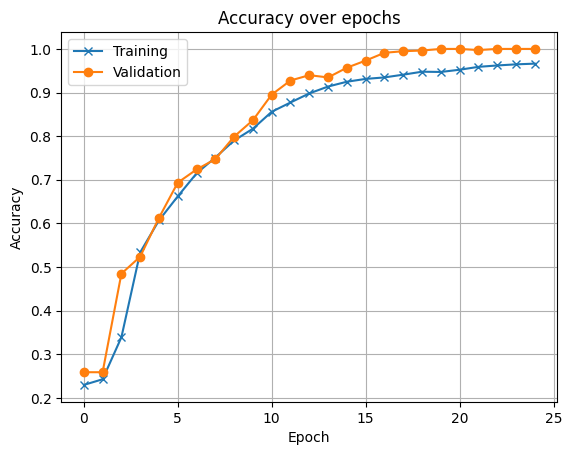

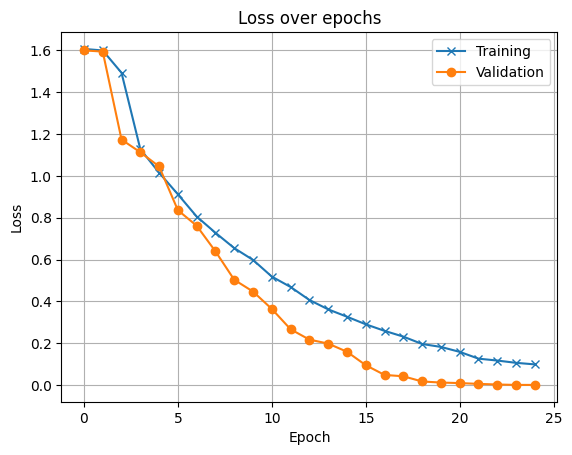

In [60]:
#Loss and Accuracy History
def plot_accuracies(history):
    accuracies = [x['train_acc'] for x in history[1:]] # Skip the first element
    val_accuracies = [x['val_acc'] for x in history[1:]] # Skip the first element
    plt.plot(accuracies, '-x')
    plt.plot(val_accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy over epochs')
    plt.grid(True)
    plt.show()

def plot_losses(history):
    train_losses = [x['train_loss'] for x in history[1:]] # Skip the first element
    val_losses = [x['val_loss'] for x in history[1:]] # Skip the first element
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss over epochs')
    plt.grid(True)
    plt.show()

plot_accuracies(history)
plot_losses(history)

In [62]:
# test_ds define Dataloader from the test dataset you have already allocated
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

test_result = evaluate(flower_cnn, test_dl)
print("Test Accuracy: {:.2f}%".format(test_result['val_acc'] * 100))

Test Accuracy: 99.89%


In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#This function takes predictions from test data and returns them with the actual labels.
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [65]:
#Get predictions
preds, labels = get_all_preds(flower_cnn, test_dl)

#Performance report
print("Classification Report:\n")
print(classification_report(labels, preds, target_names=original_dataset.classes))

Classification Report:

              precision    recall  f1-score   support

       daisy       1.00      1.00      1.00       162
   dandelion       1.00      1.00      1.00       223
        rose       0.99      1.00      1.00       155
   sunflower       1.00      1.00      1.00       135
       tulip       1.00      0.99      1.00       189

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



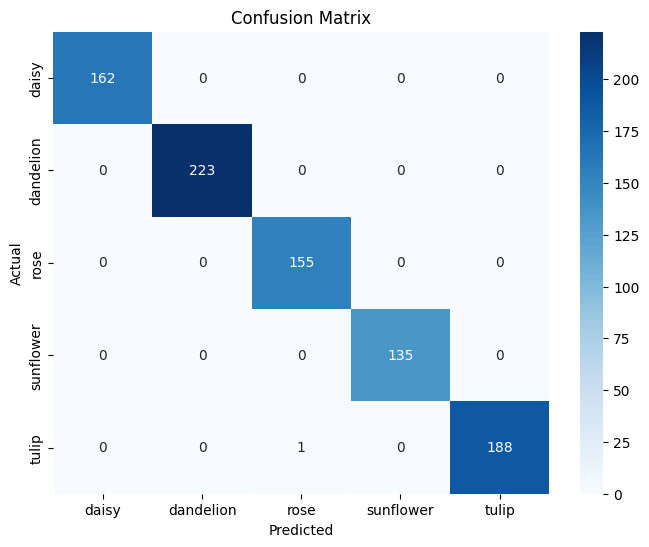

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

#confusion matrix visualization
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=original_dataset.classes, yticklabels=original_dataset.classes, cmap="Blues") # Use original_dataset.classes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

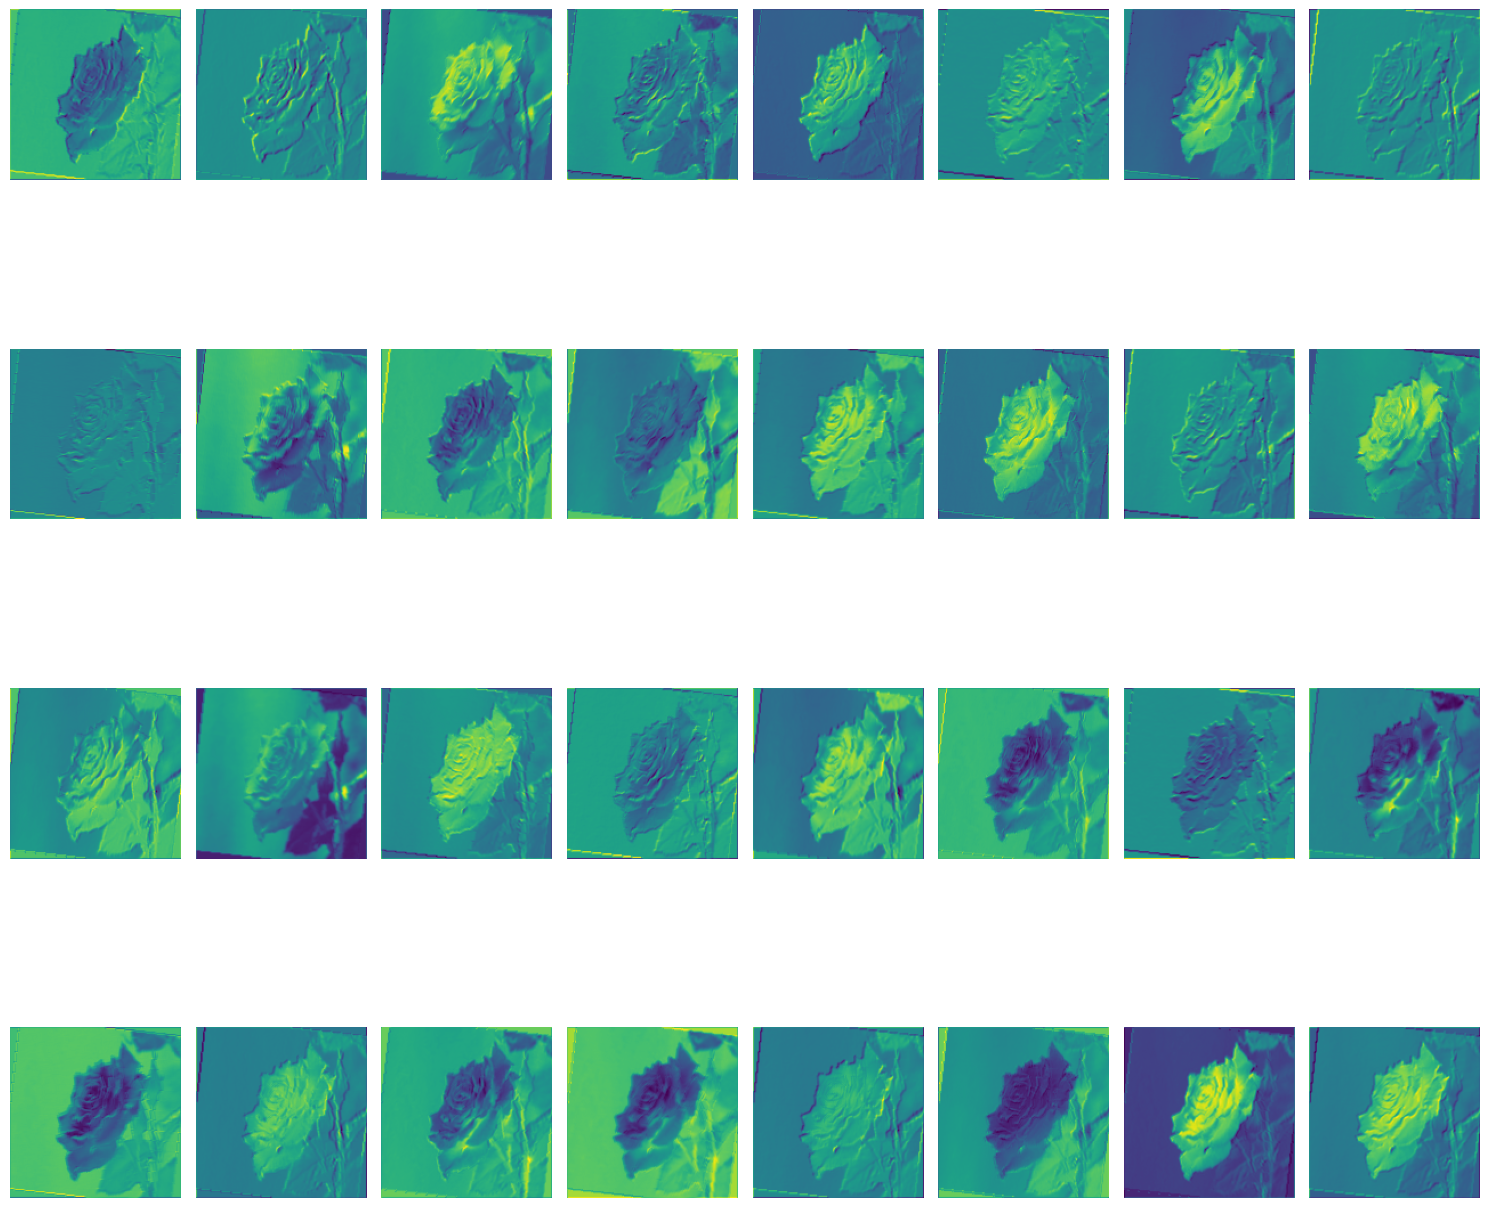

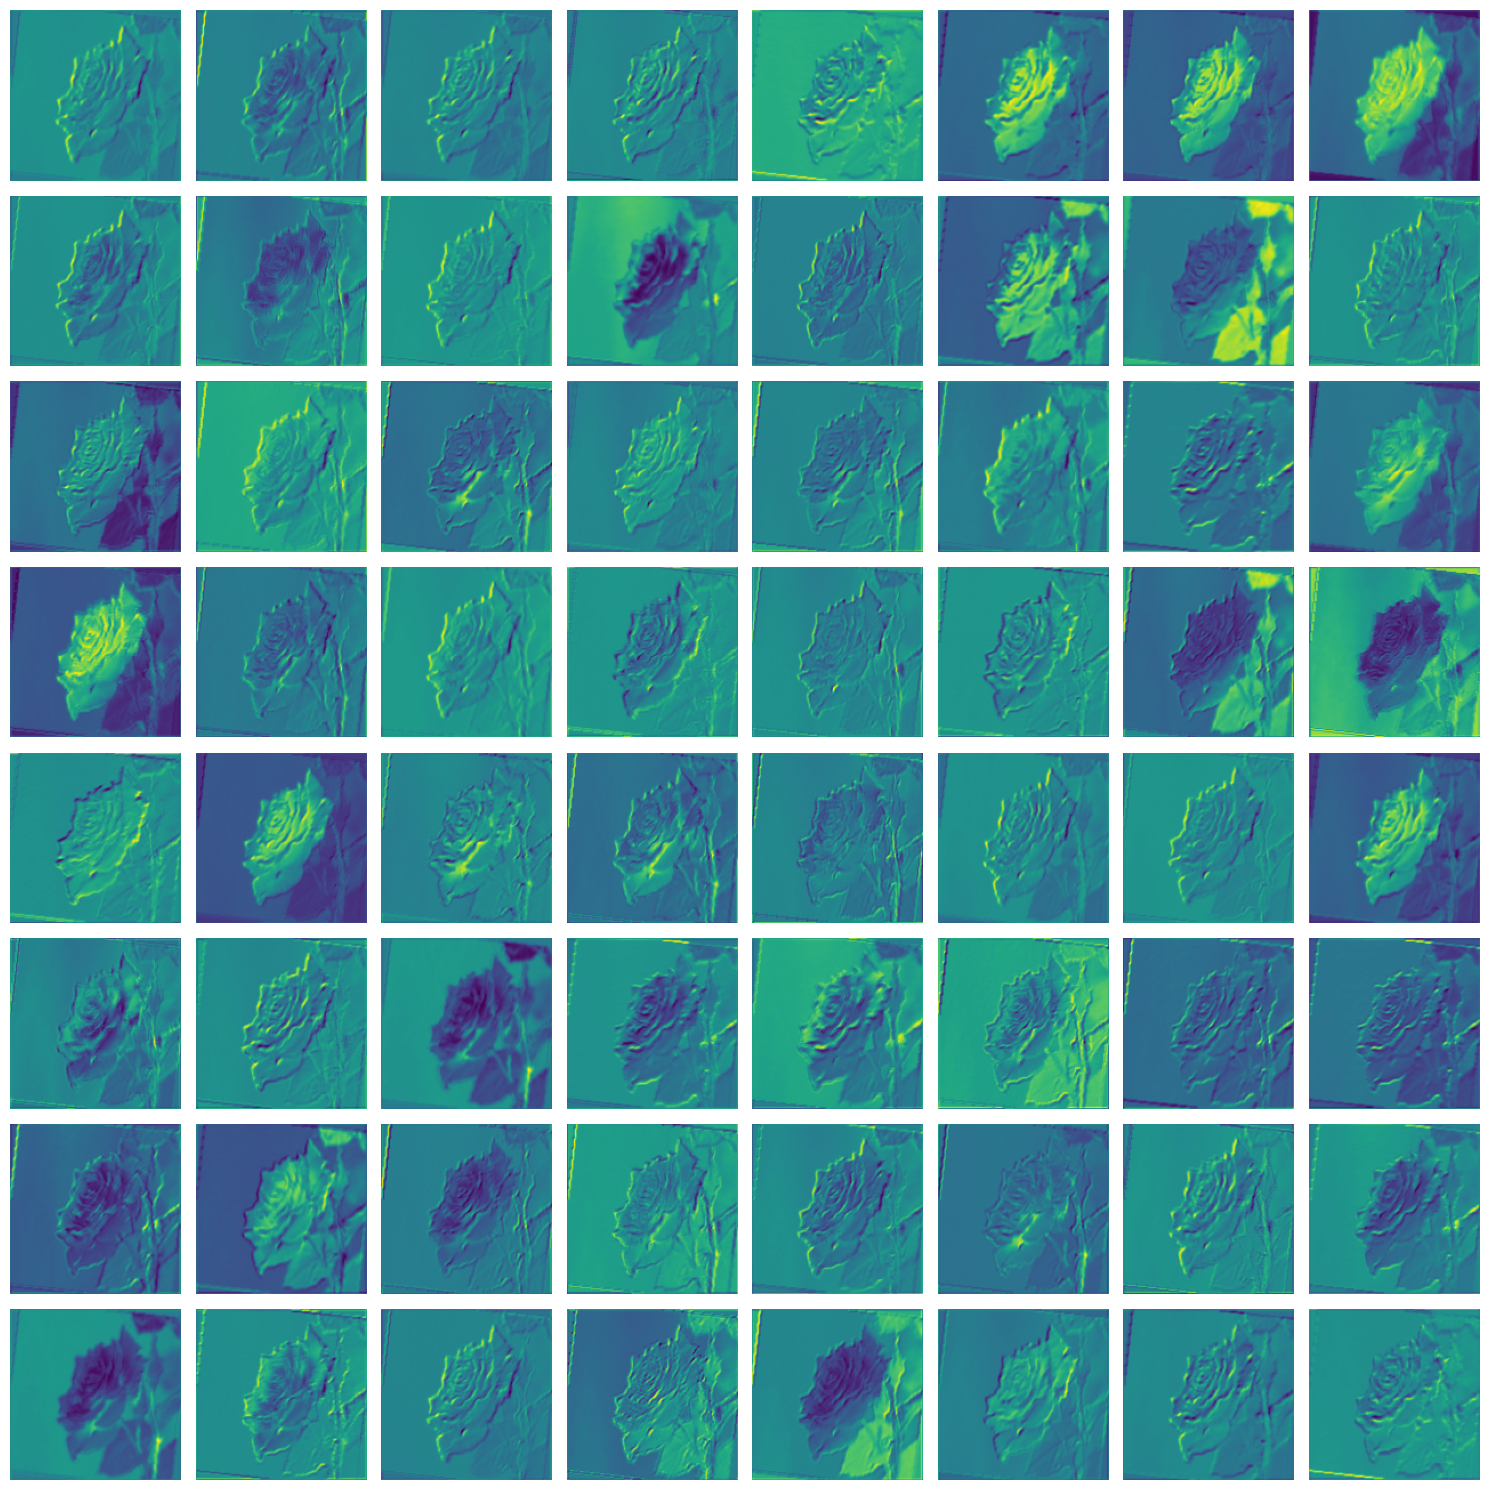

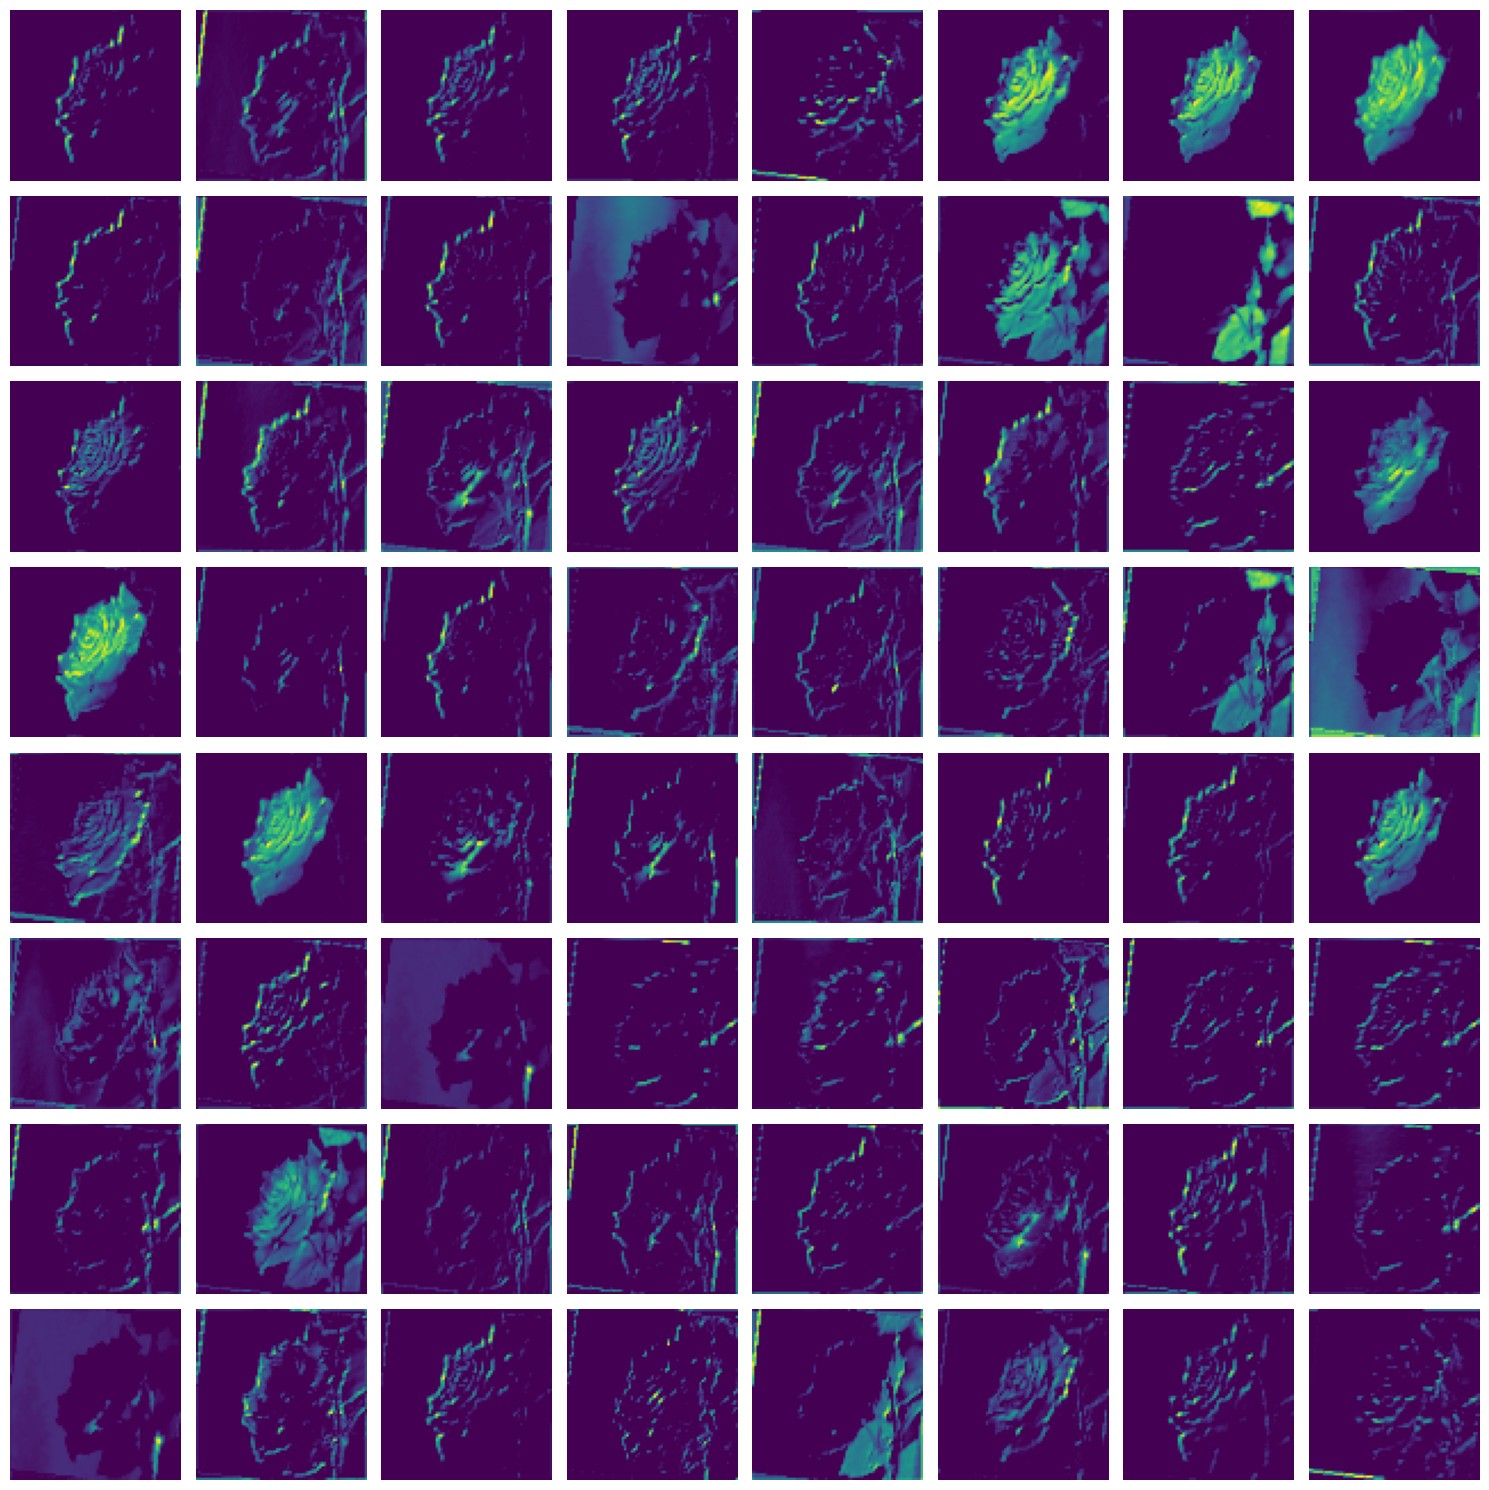

In [68]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

#It is used to visualize feature maps from different layers of the CNN model.
#Obtains intermediate activations originating from layer at layer_num.
def visualize_feature_maps(model, layer_num, input_image):
    layers = list(model.network.children())

    def hook_fn(module, input, output):
        feature_maps.append(output)

    feature_maps = []
    hook = layers[layer_num].register_forward_hook(hook_fn)


    model.eval()
    with torch.no_grad():
        _ = model(input_image)  # ileri geçiş

    hook.remove()
    return feature_maps[0]


#Visualizes feature maps frame by frame.
def plot_feature_maps(feature_map, num_cols=8):
    num_features = feature_map.size(1)
    num_rows = (num_features + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(num_features):
        ax = axes[i]
        ax.imshow(feature_map[0, i].cpu().detach().numpy(), cmap='viridis')
        ax.axis('off')


    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


for images, labels in train_dl:
    input_image = images[0].unsqueeze(0).to(device)  # [1, C, H, W]
    break


#Draw feature maps (1st, 3rd and 5th conv layers)
flower_cnn.eval()  #put the model in evaluation mode
feature_map1 = visualize_feature_maps(flower_cnn, 0, input_image)  # 1. Conv
plot_feature_maps(feature_map1)

feature_map3 = visualize_feature_maps(flower_cnn, 2, input_image)  # 3. Conv
plot_feature_maps(feature_map3)

feature_map5 = visualize_feature_maps(flower_cnn, 4, input_image)  # 5. Conv
plot_feature_maps(feature_map5)